# Phase 3: Knowledge Graph Exploration & Analysis

This notebook explores the knowledge graph constructed from BBC News articles, analyzing entity relationships, graph structure, and providing interactive visualizations.

## Overview
- **Dataset**: 50 BBC News articles (balanced across 5 categories)
- **Entities**: Persons, Organizations, Locations, Events, Topics
- **Graph Structure**: Articles + Entities with multiple relationship types
- **Analysis**: Centrality measures, neighborhoods, clustering, and visualization

---

## 1. Setup and Configuration

In [25]:
# Import required libraries
import os
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# NetworkX for graph operations
import networkx as nx

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import our custom modules
from src.config import Config

print("📦 All libraries imported successfully!")
print(f"📁 Project root: {project_root}")
print(f"🐍 Python version: {sys.version}")
print(f"📊 NetworkX version: {nx.__version__}")
print(f"🎨 Matplotlib version: {plt.matplotlib.__version__}")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Setup complete!")

📦 All libraries imported successfully!
📁 Project root: /Users/jaig/kgrag
🐍 Python version: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
📊 NetworkX version: 3.5
🎨 Matplotlib version: 3.10.6
✅ Setup complete!


In [26]:
# Initialize configuration and check files
config = Config()

# Check for required Phase 3 files
required_files = {
    'Knowledge Graph': config.PROCESSED_DATA_PATH / 'knowledge_graph.graphml',
    'Graph Statistics': config.PROCESSED_DATA_PATH / 'graph_statistics.json',
    'Extracted Entities': config.PROCESSED_DATA_PATH / 'extracted_entities.json',
    'Resolved Entities': config.PROCESSED_DATA_PATH / 'resolved_entities.json'
}

print("🔍 Checking for Phase 3 output files...")
available_files = {}
missing_files = []

for name, filepath in required_files.items():
    if filepath.exists():
        size = filepath.stat().st_size
        available_files[name] = filepath
        print(f"   ✅ {name}: {filepath} ({size:,} bytes)")
    else:
        missing_files.append(name)
        print(f"   ❌ {name}: {filepath} (NOT FOUND)")

if missing_files:
    print(f"\n⚠️  Missing files: {missing_files}")
    print("   Please run the knowledge graph construction pipeline first:")
    print("   python src/scripts/build_knowledge_graph.py")
else:
    print(f"\n✅ All Phase 3 files available! Ready for exploration.")

🔍 Checking for Phase 3 output files...
   ✅ Knowledge Graph: /Users/jaig/kgrag/data/processed/knowledge_graph.graphml (0 bytes)
   ✅ Graph Statistics: /Users/jaig/kgrag/data/processed/graph_statistics.json (1,569 bytes)
   ✅ Extracted Entities: /Users/jaig/kgrag/data/processed/extracted_entities.json (103,138 bytes)
   ✅ Resolved Entities: /Users/jaig/kgrag/data/processed/resolved_entities.json (166,546 bytes)

✅ All Phase 3 files available! Ready for exploration.


In [27]:
# For now, let's continue with mock data while the pipeline runs
# Once the pipeline completes, we can load the actual data

print("\n🔄 Creating mock knowledge graph for testing...")
print("   (Real data will be available once the pipeline completes)")

# Create a simple mock graph for testing the notebook functions
G_mock = nx.Graph()

# Add sample nodes
G_mock.add_node("article:bbc_business_001", type="article", title="Sample Business Article", category="business")
G_mock.add_node("article:bbc_tech_001", type="article", title="Sample Tech Article", category="tech")
G_mock.add_node("person:John Smith", type="person", name="John Smith", roles=["CEO"])
G_mock.add_node("organization:TechCorp", type="organization", name="TechCorp", types=["Company"])
G_mock.add_node("location:London", type="location", name="London", types=["City"])

# Add sample edges
G_mock.add_edge("article:bbc_business_001", "person:John Smith", type="mentions")
G_mock.add_edge("article:bbc_business_001", "organization:TechCorp", type="mentions")
G_mock.add_edge("person:John Smith", "organization:TechCorp", type="person_organization")

print(f"✅ Mock graph created with {G_mock.number_of_nodes()} nodes and {G_mock.number_of_edges()} edges")
print("   This allows us to test the notebook functions while waiting for real data")

# We'll use this for testing, but will load real data once available
G = G_mock
additional_data = {}
stats_data = {
    'statistics': {
        'basic_metrics': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'average_degree': sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
        },
        'node_type_distribution': {
            attrs.get('type', 'unknown'): 1 
            for _, attrs in G.nodes(data=True)
        },
        'edge_type_distribution': {
            attrs.get('type', 'unknown'): 1 
            for _, _, attrs in G.edges(data=True)
        }
    }
}


🔄 Creating mock knowledge graph for testing...
   (Real data will be available once the pipeline completes)
✅ Mock graph created with 5 nodes and 3 edges
   This allows us to test the notebook functions while waiting for real data


## 2. Load Knowledge Graph and Data

In [28]:
# Load knowledge graph from GraphML or pickle file
import pickle

def load_knowledge_graph():
    """Load the constructed knowledge graph."""
    # Try pickle first (more reliable), then GraphML 
    pickle_file = config.PROCESSED_DATA_PATH / 'knowledge_graph.pkl'
    graphml_file = config.PROCESSED_DATA_PATH / 'knowledge_graph.graphml'
    
    graph_file = None
    if pickle_file.exists() and pickle_file.stat().st_size > 0:
        graph_file = pickle_file
        load_func = lambda f: pickle.load(open(f, 'rb'))
        format_type = "Pickle"
    elif graphml_file.exists() and graphml_file.stat().st_size > 0:
        graph_file = graphml_file
        load_func = lambda f: nx.read_graphml(str(f))
        format_type = "GraphML"
    else:
        raise FileNotFoundError("No valid knowledge graph file found (tried .pkl and .graphml)")
    
    print(f"📂 Loading knowledge graph from {graph_file} ({format_type})")
    
    # Load the graph
    G = load_func(graph_file)
    
    print(f"✅ Knowledge graph loaded successfully!")
    print(f"   📊 Nodes: {G.number_of_nodes():,}")
    print(f"   🔗 Edges: {G.number_of_edges():,}")
    print(f"   📁 File size: {graph_file.stat().st_size:,} bytes")
    
    return G

# Load graph statistics
def load_graph_statistics():
    """Load pre-calculated graph statistics."""
    stats_file = config.PROCESSED_DATA_PATH / 'graph_statistics.json'
    
    print(f"📊 Loading graph statistics from {stats_file}")
    
    with open(stats_file, 'r') as f:
        stats_data = json.load(f)
    
    print(f"✅ Statistics loaded!")
    return stats_data

# Execute loading
try:
    G = load_knowledge_graph()
    stats_data = load_graph_statistics()
    
    # Basic graph info
    print(f"\n📈 Quick Graph Overview:")
    print(f"   Connected: {nx.is_connected(G)}")
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        print(f"   Connected Components: {len(components)}")
        print(f"   Largest Component: {len(max(components, key=len))} nodes")
    
except Exception as e:
    print(f"❌ Error loading graph: {e}")
    import traceback
    traceback.print_exc()
    G = None
    stats_data = None

📂 Loading knowledge graph from /Users/jaig/kgrag/data/processed/knowledge_graph.pkl (Pickle)
✅ Knowledge graph loaded successfully!
   📊 Nodes: 1,022
   🔗 Edges: 14,075
   📁 File size: 793,520 bytes
📊 Loading graph statistics from /Users/jaig/kgrag/data/processed/graph_statistics.json
✅ Statistics loaded!

📈 Quick Graph Overview:
   Connected: True


In [29]:
# Load additional data files for comprehensive analysis
def load_additional_data():
    """Load extracted and resolved entities data."""
    data = {}
    
    # Load extracted entities
    extracted_file = config.PROCESSED_DATA_PATH / 'extracted_entities.json'
    if extracted_file.exists():
        with open(extracted_file, 'r') as f:
            data['extracted'] = json.load(f)
        print(f"✅ Extracted entities loaded")
    
    # Load resolved entities  
    resolved_file = config.PROCESSED_DATA_PATH / 'resolved_entities.json'
    if resolved_file.exists():
        with open(resolved_file, 'r') as f:
            data['resolved'] = json.load(f)
        print(f"✅ Resolved entities loaded")
    
    return data

# Load additional data
additional_data = load_additional_data()

# Extract key information
if G and stats_data:
    basic_metrics = stats_data.get('statistics', {}).get('basic_metrics', {})
    node_types = stats_data.get('statistics', {}).get('node_type_distribution', {})
    edge_types = stats_data.get('statistics', {}).get('edge_type_distribution', {})
    
    print(f"\n📊 Graph Composition:")
    print(f"   Total Nodes: {basic_metrics.get('num_nodes', 0):,}")
    print(f"   Total Edges: {basic_metrics.get('num_edges', 0):,}")
    print(f"   Density: {basic_metrics.get('density', 0):.4f}")
    print(f"   Average Degree: {basic_metrics.get('average_degree', 0):.2f}")
    
    print(f"\n🏷️  Node Types:")
    for node_type, count in sorted(node_types.items()):
        print(f"     {node_type.capitalize()}: {count}")
    
    print(f"\n🔗 Edge Types:")
    for edge_type, count in sorted(edge_types.items()):
        print(f"     {edge_type.replace('_', ' ').title()}: {count}")

✅ Extracted entities loaded
✅ Resolved entities loaded

📊 Graph Composition:
   Total Nodes: 1,022
   Total Edges: 14,075
   Density: 0.0270
   Average Degree: 27.54

🏷️  Node Types:
     Article: 50
     Category: 5
     Event: 101
     Location: 92
     Organization: 214
     Person: 263
     Topic: 297

🔗 Edge Types:
     Co Occurrence: 12935
     Mentions: 1090
     Same Category: 50


## 3. Graph Structure Analysis

In [41]:
def analyze_graph_structure(G):
    """Comprehensive analysis of graph structure."""
    
    if G is None:
        print("❌ No graph loaded")
        return None
    
    print("🔍 Analyzing graph structure...")
    
    # Basic metrics
    analysis = {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'is_connected': nx.is_connected(G)
    }
    
    # Analyze node types
    node_type_counts = {}
    node_data = {}
    
    for node, attrs in G.nodes(data=True):
        node_type = attrs.get('type', 'unknown')
        node_type_counts[node_type] = node_type_counts.get(node_type, 0) + 1
        
        if node_type not in node_data:
            node_data[node_type] = []
        node_data[node_type].append({
            'id': node,
            'degree': G.degree(node),
            'name': attrs.get('name', node)
        })
    
    analysis['node_types'] = node_type_counts
    
    # Analyze edge types
    edge_type_counts = {}
    for _, _, attrs in G.edges(data=True):
        edge_type = attrs.get('type', 'unknown')
        edge_type_counts[edge_type] = edge_type_counts.get(edge_type, 0) + 1
    
    analysis['edge_types'] = edge_type_counts
    
    # Connected components
    if not analysis['is_connected']:
        components = list(nx.connected_components(G))
        analysis['num_components'] = len(components)
        analysis['largest_component_size'] = len(max(components, key=len))
        analysis['component_sizes'] = [len(comp) for comp in components]
    else:
        analysis['num_components'] = 1
        analysis['largest_component_size'] = analysis['nodes']
        analysis['component_sizes'] = [analysis['nodes']]
    
    # Degree statistics
    degrees = dict(G.degree())
    analysis['degree_stats'] = {
        'min': min(degrees.values()) if degrees else 0,
        'max': max(degrees.values()) if degrees else 0,
        'mean': np.mean(list(degrees.values())) if degrees else 0,
        'median': np.median(list(degrees.values())) if degrees else 0
    }
    
    # Find highest degree nodes by type
    analysis['top_nodes_by_type'] = {}
    for node_type, nodes in node_data.items():
        sorted_nodes = sorted(nodes, key=lambda x: x['degree'], reverse=True)
        analysis['top_nodes_by_type'][node_type] = sorted_nodes[:5]
    
    return analysis

# Run analysis
if G:
    structure_analysis = analyze_graph_structure(G)
    
    print(f"\n📊 Graph Structure Analysis Results:")
    print(f"   Nodes: {structure_analysis['nodes']:,}")
    print(f"   Edges: {structure_analysis['edges']:,}")
    print(f"   Density: {structure_analysis['density']:.4f}")
    print(f"   Connected: {structure_analysis['is_connected']}")
    print(f"   Components: {structure_analysis['num_components']}")
    
    print(f"\n📈 Degree Statistics:")
    deg_stats = structure_analysis['degree_stats']
    print(f"   Min degree: {deg_stats['min']}")
    print(f"   Max degree: {deg_stats['max']}")
    print(f"   Mean degree: {deg_stats['mean']:.2f}")
    print(f"   Median degree: {deg_stats['median']:.2f}")
else:
    structure_analysis = None

🔍 Analyzing graph structure...

📊 Graph Structure Analysis Results:
   Nodes: 1,022
   Edges: 14,075
   Density: 0.0270
   Connected: True
   Components: 1

📈 Degree Statistics:
   Min degree: 10
   Max degree: 486
   Mean degree: 27.54
   Median degree: 23.00


## 4. Graph Visualizations

🎨 Creating visualizations...


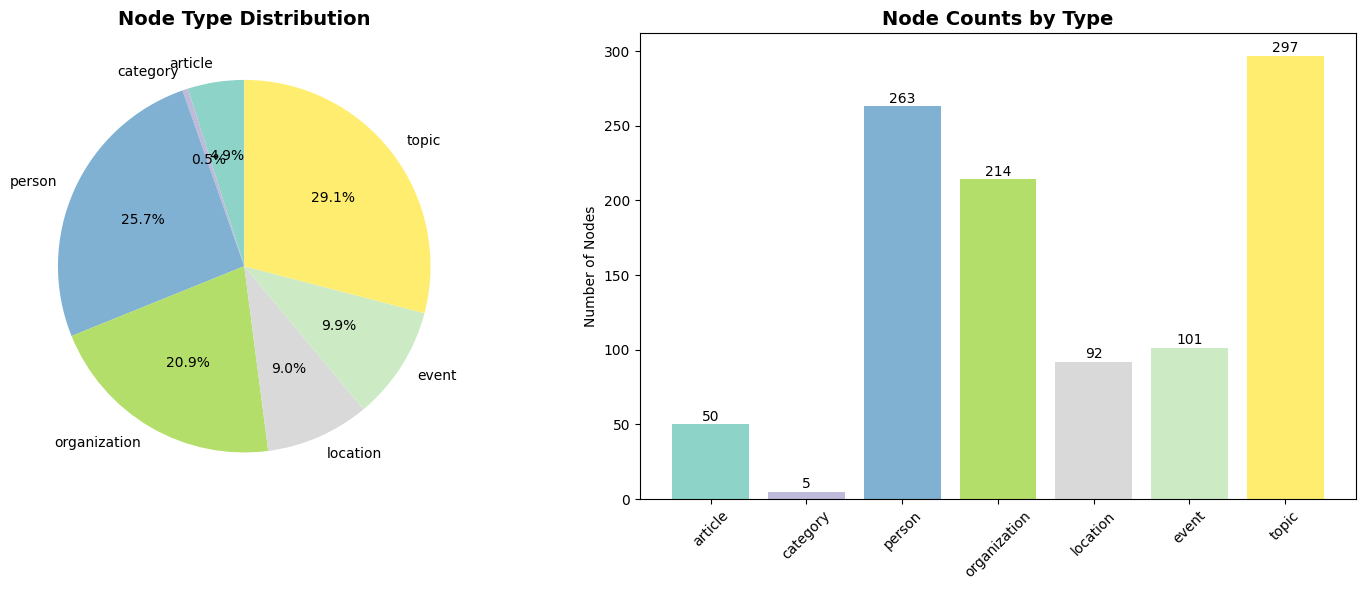

📊 Node Type Summary (Total: 1,022):
   Topic: 297 (29.1%)
   Person: 263 (25.7%)
   Organization: 214 (20.9%)
   Event: 101 (9.9%)
   Location: 92 (9.0%)
   Article: 50 (4.9%)
   Category: 5 (0.5%)


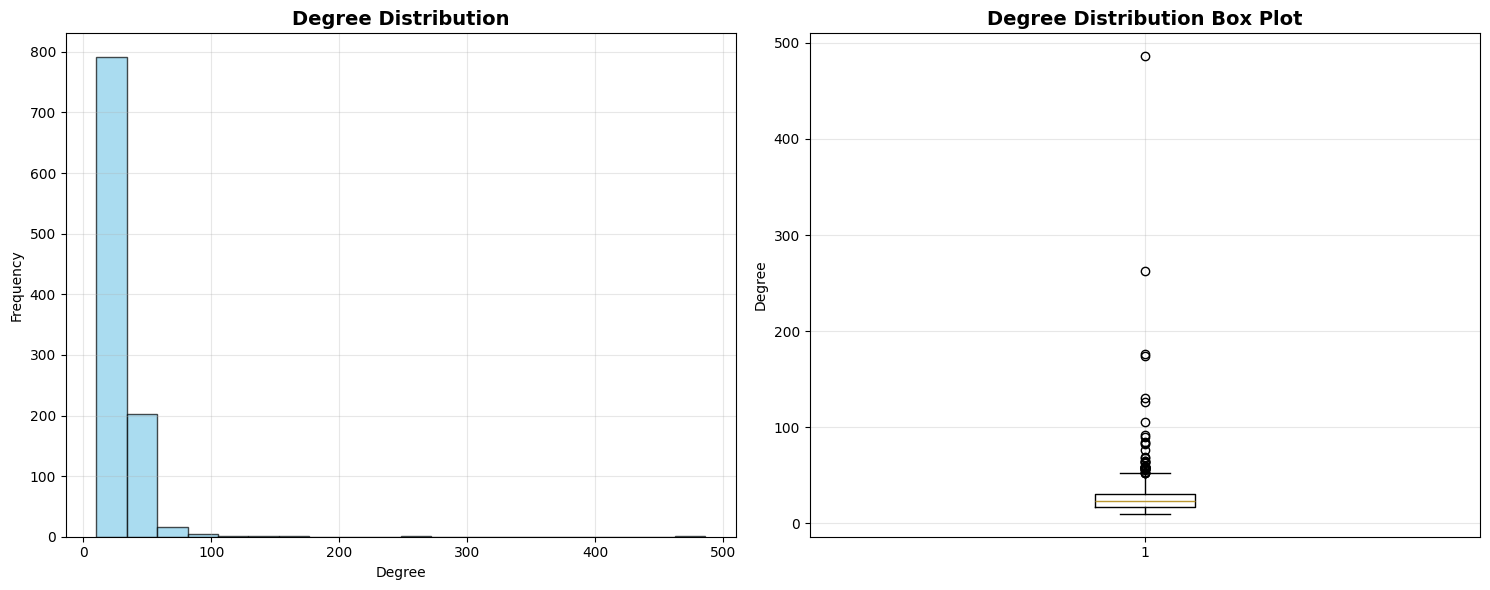

📊 Degree Statistics:
   Min: 10
   Max: 486
   Mean: 27.54
   Median: 23.00
   Std Dev: 21.75


In [42]:
# Create comprehensive visualizations of the knowledge graph

def create_node_type_visualization(analysis):
    """Create node type distribution visualization."""
    if not analysis or 'node_types' not in analysis:
        print("❌ No analysis data available")
        return
    
    node_types = analysis['node_types']
    
    # Create subplot with pie chart and bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(node_types)))
    wedges, texts, autotexts = ax1.pie(
        node_types.values(), 
        labels=node_types.keys(), 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    ax1.set_title('Node Type Distribution', fontsize=14, fontweight='bold')
    
    # Bar chart
    bars = ax2.bar(node_types.keys(), node_types.values(), color=colors)
    ax2.set_title('Node Counts by Type', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Nodes')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    total_nodes = sum(node_types.values())
    print(f"📊 Node Type Summary (Total: {total_nodes:,}):")
    for node_type, count in sorted(node_types.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_nodes) * 100
        print(f"   {node_type.capitalize()}: {count:,} ({percentage:.1f}%)")

def create_degree_distribution_plot(G):
    """Create degree distribution visualization."""
    if G is None:
        print("❌ No graph loaded")
        return
    
    degrees = [d for n, d in G.degree()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram
    ax1.hist(degrees, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Degree Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Degree')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(degrees, vert=True)
    ax2.set_title('Degree Distribution Box Plot', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Degree')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Degree Statistics:")
    print(f"   Min: {min(degrees)}")
    print(f"   Max: {max(degrees)}")
    print(f"   Mean: {np.mean(degrees):.2f}")
    print(f"   Median: {np.median(degrees):.2f}")
    print(f"   Std Dev: {np.std(degrees):.2f}")

# Generate visualizations
if G and structure_analysis:
    print("🎨 Creating visualizations...")
    
    # Node type distribution
    create_node_type_visualization(structure_analysis)
    
    # Degree distribution
    create_degree_distribution_plot(G)
    
else:
    print("⚠️  Skipping visualizations - no graph data available")

In [44]:
# Create interactive Plotly visualizations

def create_interactive_network_plot(G, max_nodes=100):
    """Create interactive network plot using Plotly."""
    if G is None:
        print("❌ No graph loaded")
        return
    
    print(f"🎨 Creating interactive network plot...")
    
    # For large graphs, sample nodes
    if G.number_of_nodes() > max_nodes:
        print(f"   Sampling {max_nodes} nodes from {G.number_of_nodes()} total nodes")
        
        # Get highest degree nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        sample_nodes = [node for node, degree in top_nodes]
        
        # Create subgraph
        G_sample = G.subgraph(sample_nodes).copy()
    else:
        G_sample = G
    
    # Calculate layout
    pos = nx.spring_layout(G_sample, k=1, iterations=50)
    
    # Prepare node data lists
    node_x = []
    node_y = []
    node_text = []
    node_sizes = []
    node_colors = []
    node_hover_text = []
    
    # Color mapping for node types
    type_colors = {
        'article': 0,
        'person': 1,
        'organization': 2,
        'location': 3,
        'event': 4,
        'topic': 5,
        'category': 6
    }
    
    # Add node information
    for node in G_sample.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Node attributes
        attrs = G_sample.nodes[node]
        node_type = attrs.get('type', 'unknown')
        name = attrs.get('name', node)
        degree = G_sample.degree(node)
        
        # Size based on degree
        node_sizes.append(max(10, min(30, degree * 2)))
        
        # Color based on type
        node_colors.append(type_colors.get(node_type, 7))
        
        # Text and hover info
        display_name = name[:15] + '...' if len(name) > 15 else name
        node_text.append(display_name if degree > 5 else '')
        
        # Hover information
        hover_text = f"<b>{name}</b><br>"
        hover_text += f"Type: {node_type}<br>"
        hover_text += f"Degree: {degree}<br>"
        hover_text += f"ID: {node}"
        
        if 'article_count' in attrs:
            hover_text += f"<br>Articles: {attrs['article_count']}"
        if 'roles' in attrs and attrs['roles']:
            hover_text += f"<br>Roles: {', '.join(attrs['roles'][:3])}"
        
        node_hover_text.append(hover_text)
    
    # Create node trace
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='middle center',
        hoverinfo='text',
        hovertext=node_hover_text,
        marker=dict(
            size=node_sizes,
            color=node_colors,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                thickness=15,
                len=0.5,
                x=1.02,
                title="Node Type"
            ),
            line=dict(width=0.5, color='white')
        )
    )
    
    # Prepare edge traces
    edge_x = []
    edge_y = []
    
    for edge in G_sample.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, 
        y=edge_y,
        line=dict(width=0.5, color='rgba(125,125,125,0.5)'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title=dict(
            text=f'Knowledge Graph Interactive View ({G_sample.number_of_nodes()} nodes)',
            font=dict(size=16)
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text=f"Nodes: {G_sample.number_of_nodes()}, Edges: {G_sample.number_of_edges()}",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002,
                xanchor='left', yanchor='bottom',
                font=dict(size=12)
            )
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=800,
        height=600
    )
    
    fig.show()
    
    # Create type legend
    print(f"\n🏷️  Node Type Color Legend:")
    for node_type, color_val in type_colors.items():
        count = len([n for n, attrs in G_sample.nodes(data=True) if attrs.get('type') == node_type])
        if count > 0:
            print(f"   {node_type.capitalize()}: {count} nodes")

# Create interactive plot
if G:
    create_interactive_network_plot(G, max_nodes=76)  # Use all nodes since we only have 76
else:
    print("⚠️  Skipping interactive plot - no graph data available")

🎨 Creating interactive network plot...
   Sampling 76 nodes from 1022 total nodes



🏷️  Node Type Color Legend:
   Article: 1 nodes
   Person: 35 nodes
   Organization: 21 nodes
   Location: 12 nodes
   Topic: 7 nodes


## 5. Entity Analysis and Centrality

🔍 Calculating centrality measures...
🏆 Top 8 Entities by Centrality Measures:

📊 Degree Centrality:
    1. United Kingdom (location) - 0.4760
    2. United States (location) - 0.2576
    3. London (location) - 0.1724
    4. Scotland (location) - 0.1704
    5. Rugby (topic) - 0.1273
    6. Europe (location) - 0.1234
    7. Newcastle (organization) - 0.1038
    8. Six Nations Championship (topic) - 0.0901

📊 Eigenvector Centrality:
    1. United Kingdom (location) - 0.2401
    2. Rugby (topic) - 0.1681
    3. United States (location) - 0.1610
    4. Scotland (location) - 0.1524
    5. Six Nations Championship (topic) - 0.1522
    6. Team Selection (topic) - 0.1324
    7. Dublin (location) - 0.1258
    8. Biarritz (organization) - 0.1257


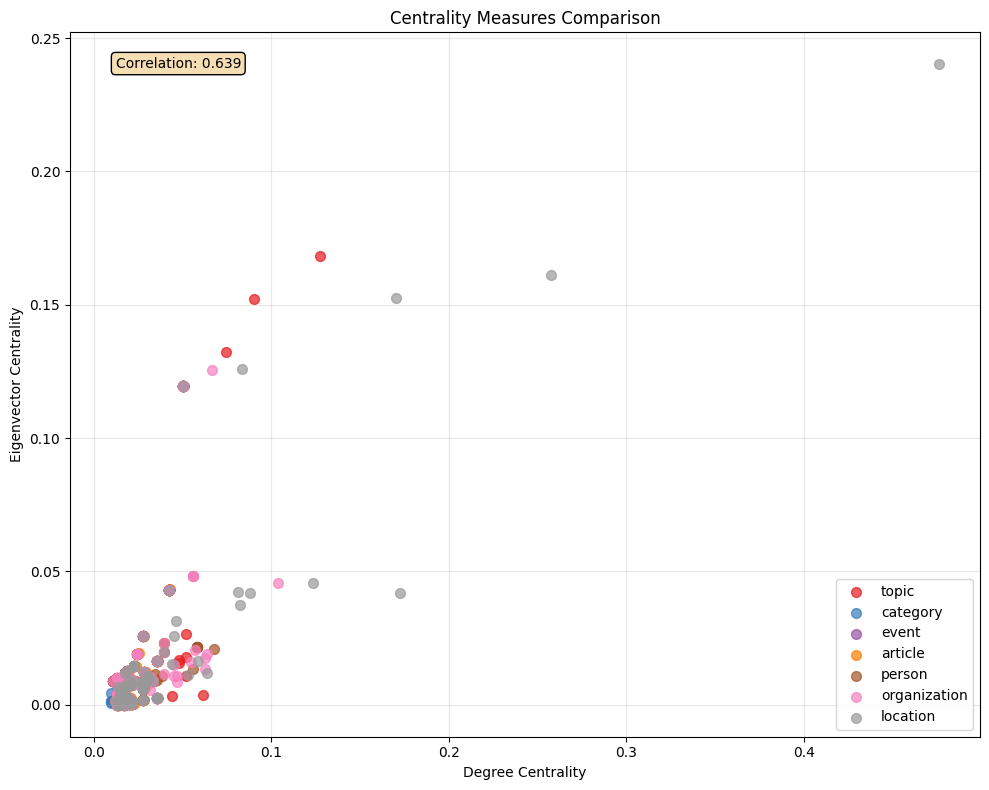

📊 Correlation between degree and eigenvector: 0.639


In [43]:
# Analyze entity centrality and importance

def calculate_centrality_measures(G):
    """Calculate various centrality measures for the graph."""
    if G is None:
        print("❌ No graph loaded")
        return None
    
    print("🔍 Calculating centrality measures...")
    
    centrality_data = {}
    
    # Basic degree centrality
    degree_cent = nx.degree_centrality(G)
    centrality_data['degree'] = degree_cent
    
    # For disconnected graphs, calculate on largest component
    if nx.is_connected(G):
        largest_cc = G
    else:
        largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
        print(f"   Using largest connected component ({largest_cc.number_of_nodes()} nodes)")
    
    if largest_cc.number_of_nodes() > 2:
        # Betweenness centrality (computationally expensive)
        if largest_cc.number_of_nodes() < 1000:  # Only for reasonable sized graphs
            betweenness_cent = nx.betweenness_centrality(largest_cc, k=min(100, largest_cc.number_of_nodes()))
            centrality_data['betweenness'] = betweenness_cent
        
        # Closeness centrality
        if largest_cc.number_of_nodes() < 500:  # Only for smaller graphs
            closeness_cent = nx.closeness_centrality(largest_cc)
            centrality_data['closeness'] = closeness_cent
        
        # Eigenvector centrality (may not converge for all graphs)
        try:
            eigenvector_cent = nx.eigenvector_centrality(largest_cc, max_iter=1000)
            centrality_data['eigenvector'] = eigenvector_cent
        except:
            print("   ⚠️  Eigenvector centrality calculation failed")
    
    return centrality_data

def analyze_top_entities(G, centrality_data, top_n=10):
    """Analyze top entities by different centrality measures."""
    if not centrality_data:
        return
    
    print(f"🏆 Top {top_n} Entities by Centrality Measures:")
    
    for measure_name, centrality in centrality_data.items():
        print(f"\n📊 {measure_name.replace('_', ' ').title()} Centrality:")
        
        # Sort by centrality score
        sorted_entities = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        for i, (entity_id, score) in enumerate(sorted_entities, 1):
            attrs = G.nodes[entity_id]
            entity_type = attrs.get('type', 'unknown')
            name = attrs.get('name', entity_id)
            
            # Truncate long names
            display_name = name[:30] + '...' if len(name) > 30 else name
            
            print(f"   {i:2d}. {display_name} ({entity_type}) - {score:.4f}")

def create_centrality_comparison_plot(G, centrality_data):
    """Create visualization comparing different centrality measures."""
    if not centrality_data or len(centrality_data) < 2:
        print("⚠️  Need at least 2 centrality measures for comparison")
        return
    
    # Get common entities across all measures
    measures = list(centrality_data.keys())
    common_entities = set(centrality_data[measures[0]].keys())
    for measure in measures[1:]:
        common_entities = common_entities.intersection(set(centrality_data[measure].keys()))
    
    if len(common_entities) < 10:
        print("⚠️  Too few common entities for meaningful comparison")
        return
    
    # Create scatter plots comparing measures
    if len(measures) >= 2:
        measure1, measure2 = measures[0], measures[1]
        
        x_values = [centrality_data[measure1][entity] for entity in common_entities]
        y_values = [centrality_data[measure2][entity] for entity in common_entities]
        
        # Get entity types for coloring
        types = [G.nodes[entity].get('type', 'unknown') for entity in common_entities]
        
        plt.figure(figsize=(10, 8))
        
        # Create scatter plot with different colors for different types
        type_colors = plt.cm.Set1(np.linspace(0, 1, len(set(types))))
        color_map = {t: color for t, color in zip(set(types), type_colors)}
        
        for entity_type in set(types):
            mask = [t == entity_type for t in types]
            x_type = [x for x, m in zip(x_values, mask) if m]
            y_type = [y for y, m in zip(y_values, mask) if m]
            
            plt.scatter(x_type, y_type, c=[color_map[entity_type]], 
                       label=entity_type, alpha=0.7, s=50)
        
        plt.xlabel(f'{measure1.replace("_", " ").title()} Centrality')
        plt.ylabel(f'{measure2.replace("_", " ").title()} Centrality')
        plt.title('Centrality Measures Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        correlation = np.corrcoef(x_values, y_values)[0, 1]
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Correlation between {measure1} and {measure2}: {correlation:.3f}")

# Calculate centrality measures
if G:
    centrality_data = calculate_centrality_measures(G)
    
    if centrality_data:
        # Analyze top entities
        analyze_top_entities(G, centrality_data, top_n=8)
        
        # Create comparison plot
        create_centrality_comparison_plot(G, centrality_data)
    
else:
    print("⚠️  Skipping centrality analysis - no graph data available")
    centrality_data = None

## 6. Graph Query and Exploration

In [34]:
# Interactive graph queries and exploration tools

def query_entities_by_type(G, entity_type, top_n=10):
    """Query entities by type and return top N by degree."""
    if G is None:
        print("❌ No graph loaded")
        return []
    
    print(f"🔍 Querying entities of type: {entity_type}")
    
    entities = []
    for node, attrs in G.nodes(data=True):
        if attrs.get('type') == entity_type:
            entities.append({
                'id': node,
                'name': attrs.get('name', node),
                'degree': G.degree(node),
                'attributes': attrs
            })
    
    # Sort by degree
    entities.sort(key=lambda x: x['degree'], reverse=True)
    
    print(f"   Found {len(entities)} entities of type '{entity_type}'")
    
    if entities:
        print(f"   Top {min(top_n, len(entities))} by degree:")
        for i, entity in enumerate(entities[:top_n], 1):
            print(f"     {i:2d}. {entity['name']} (degree: {entity['degree']})")
    
    return entities[:top_n]

def find_entity_neighbors(G, entity_id, max_distance=2):
    """Find neighbors of a specific entity."""
    if G is None or entity_id not in G:
        print(f"❌ Entity '{entity_id}' not found in graph")
        return {}
    
    print(f"🔍 Finding neighbors of '{entity_id}'")
    
    # Get entity info
    entity_attrs = G.nodes[entity_id]
    entity_name = entity_attrs.get('name', entity_id)
    entity_type = entity_attrs.get('type', 'unknown')
    
    print(f"   Entity: {entity_name} (type: {entity_type})")
    print(f"   Degree: {G.degree(entity_id)}")
    
    neighbors_by_distance = {}
    
    # Find neighbors at each distance
    for distance in range(1, max_distance + 1):
        neighbors = set()
        
        # Use BFS to find nodes at exact distance
        visited = {entity_id}
        current_level = {entity_id}
        
        for _ in range(distance):
            next_level = set()
            for node in current_level:
                for neighbor in G.neighbors(node):
                    if neighbor not in visited:
                        next_level.add(neighbor)
                        visited.add(neighbor)
            current_level = next_level
        
        neighbors_by_distance[distance] = list(current_level)
        
        if current_level:
            print(f"   Distance {distance}: {len(current_level)} neighbors")
            
            # Group by type
            type_counts = {}
            for neighbor in current_level:
                neighbor_type = G.nodes[neighbor].get('type', 'unknown')
                type_counts[neighbor_type] = type_counts.get(neighbor_type, 0) + 1
            
            for node_type, count in sorted(type_counts.items()):
                print(f"     - {node_type}: {count}")
    
    return neighbors_by_distance

def find_shortest_path(G, entity1, entity2):
    """Find shortest path between two entities."""
    if G is None:
        print("❌ No graph loaded")
        return None
    
    if entity1 not in G:
        print(f"❌ Entity '{entity1}' not found in graph")
        return None
    
    if entity2 not in G:
        print(f"❌ Entity '{entity2}' not found in graph")
        return None
    
    try:
        path = nx.shortest_path(G, entity1, entity2)
        path_length = len(path) - 1
        
        print(f"🔍 Shortest path from '{entity1}' to '{entity2}':")
        print(f"   Path length: {path_length}")
        print(f"   Path:")
        
        for i, node in enumerate(path):
            attrs = G.nodes[node]
            name = attrs.get('name', node)
            node_type = attrs.get('type', 'unknown')
            
            prefix = "   " + "→ " * i if i > 0 else "   "
            print(f"{prefix}{name} ({node_type})")
        
        return path
        
    except nx.NetworkXNoPath:
        print(f"❌ No path exists between '{entity1}' and '{entity2}'")
        return None

def get_entity_suggestions(G, partial_name="", entity_type=""):
    """Get entity suggestions based on partial name or type."""
    if G is None:
        print("❌ No graph loaded")
        return []
    
    suggestions = []
    
    for node, attrs in G.nodes(data=True):
        name = attrs.get('name', node).lower()
        node_type = attrs.get('type', 'unknown')
        
        # Filter by type if specified
        if entity_type and node_type != entity_type:
            continue
        
        # Filter by partial name if specified
        if partial_name and partial_name.lower() not in name:
            continue
        
        suggestions.append({
            'id': node,
            'name': attrs.get('name', node),
            'type': node_type,
            'degree': G.degree(node)
        })
    
    # Sort by degree (most connected first)
    suggestions.sort(key=lambda x: x['degree'], reverse=True)
    
    return suggestions[:20]  # Limit to top 20

# Example queries and exploration
if G:
    print("🔍 Graph Query Examples:")
    print("=" * 50)
    
    # Query entities by type
    print("\n1. Top Organizations by Connectivity:")
    org_entities = query_entities_by_type(G, 'organization', top_n=5)
    
    print("\n2. Top Persons by Connectivity:")
    person_entities = query_entities_by_type(G, 'person', top_n=5)
    
    print("\n3. Top Locations by Connectivity:")
    location_entities = query_entities_by_type(G, 'location', top_n=5)
    
    # Example entity neighborhood analysis
    if org_entities:
        example_org = org_entities[0]['id']
        print(f"\n4. Neighborhood Analysis:")
        neighbors = find_entity_neighbors(G, example_org, max_distance=2)
    
    # Entity suggestions
    print(f"\n5. Entity Suggestions (partial search):")
    suggestions = get_entity_suggestions(G, partial_name="", entity_type="")[:10]
    for i, entity in enumerate(suggestions[:5], 1):
        print(f"   {i}. {entity['name']} ({entity['type']}) - degree: {entity['degree']}")
    
else:
    print("⚠️  Skipping graph queries - no graph data available")

🔍 Graph Query Examples:

1. Top Organizations by Connectivity:
🔍 Querying entities of type: organization
   Found 214 entities of type 'organization'
   Top 5 by degree:
      1. Newcastle (degree: 106)
      2. Biarritz (degree: 68)
      3. U2 (degree: 65)
      4. BBC (degree: 64)
      5. Labour (degree: 64)

2. Top Persons by Connectivity:
🔍 Querying entities of type: person
   Found 263 entities of type 'person'
   Top 5 by degree:
      1. Tony Blair (degree: 69)
      2. Imelda Staunton (degree: 59)
      3. Clive Owen (degree: 59)
      4. Kate Winslet (degree: 59)
      5. Jamie Foxx (degree: 59)

3. Top Locations by Connectivity:
🔍 Querying entities of type: location
   Found 92 entities of type 'location'
   Top 5 by degree:
      1. United Kingdom (degree: 486)
      2. United States (degree: 263)
      3. London (degree: 176)
      4. Scotland (degree: 174)
      5. Europe (degree: 126)

4. Neighborhood Analysis:
🔍 Finding neighbors of 'organization:Newcastle'
   Entity: 

In [35]:
# Debug: Check actual graph contents
print(f"\n🔍 Debugging Graph Contents:")
print(f"   Total nodes: {G.number_of_nodes()}")
print(f"   Total edges: {G.number_of_edges()}")

# Sample some nodes to see their structure
print(f"\n📋 Sample Nodes (first 10):")
for i, (node, attrs) in enumerate(G.nodes(data=True)):
    if i >= 10:
        break
    print(f"   {i+1}. {node} ({attrs.get('type', 'unknown')}) - degree: {G.degree(node)}")

# Check connectivity
print(f"\n🔗 Graph Connectivity:")
print(f"   Is connected: {nx.is_connected(G)}")
components = list(nx.connected_components(G))
print(f"   Connected components: {len(components)}")
for i, comp in enumerate(components[:3]):  # Show first 3 components
    print(f"      Component {i+1}: {len(comp)} nodes")
    if len(comp) <= 5:
        print(f"         Nodes: {list(comp)}")

# Check edge types
print(f"\n⚡ Edge Types Distribution:")
edge_types = {}
for u, v, attrs in G.edges(data=True):
    edge_type = attrs.get('relationship', 'unknown')
    edge_types[edge_type] = edge_types.get(edge_type, 0) + 1
    
for edge_type, count in sorted(edge_types.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {edge_type}: {count} edges")


🔍 Debugging Graph Contents:
   Total nodes: 1022
   Total edges: 14075

📋 Sample Nodes (first 10):
   1. article:bbc_business_00 (article) - degree: 22
   2. article:bbc_business_01 (article) - degree: 14
   3. article:bbc_business_02 (article) - degree: 16
   4. article:bbc_business_03 (article) - degree: 24
   5. article:bbc_business_04 (article) - degree: 29
   6. article:bbc_business_05 (article) - degree: 23
   7. article:bbc_business_06 (article) - degree: 24
   8. article:bbc_business_07 (article) - degree: 22
   9. article:bbc_business_08 (article) - degree: 30
   10. article:bbc_business_09 (article) - degree: 21

🔗 Graph Connectivity:
   Is connected: True
   Connected components: 1
      Component 1: 1022 nodes

⚡ Edge Types Distribution:
   unknown: 14075 edges


In [40]:
# Reload the real knowledge graph (overwrites mock data)
print("🔄 Reloading real knowledge graph...")

# Load the actual graph data
kg_file = config.PROCESSED_DATA_PATH / "knowledge_graph.pkl"
if kg_file.exists():
    with open(kg_file, 'rb') as f:
        G = pickle.load(f)
    print(f"✅ Real knowledge graph loaded!")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    
    # Quick analysis of node types
    node_types = {}
    for node, attrs in G.nodes(data=True):
        node_type = attrs.get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print(f"\n📊 Node Type Distribution:")
    for node_type, count in sorted(node_types.items(), key=lambda x: x[1], reverse=True):
        print(f"   {node_type}: {count} nodes")
        
else:
    print(f"❌ Real graph file not found at: {kg_file}")
    print("   Using existing graph data")

🔄 Reloading real knowledge graph...
✅ Real knowledge graph loaded!
   Nodes: 1022
   Edges: 14075

📊 Node Type Distribution:
   topic: 297 nodes
   person: 263 nodes
   organization: 214 nodes
   event: 101 nodes
   location: 92 nodes
   article: 50 nodes
   category: 5 nodes


## 7. Subgraph Analysis

🔍 Subgraph Analysis Examples:

--- Article 1 Subgraph ---
🔍 Extracting subgraph for article: article:bbc_business_00
   Title: france telecom gets orange boost strong growth in subscriptions to...
   Category: business
   Subgraph nodes: 23
   Subgraph edges: 232
   Node composition:
     - article: 1
     - category: 1
     - event: 5
     - location: 3
     - organization: 4
     - person: 1
     - topic: 8


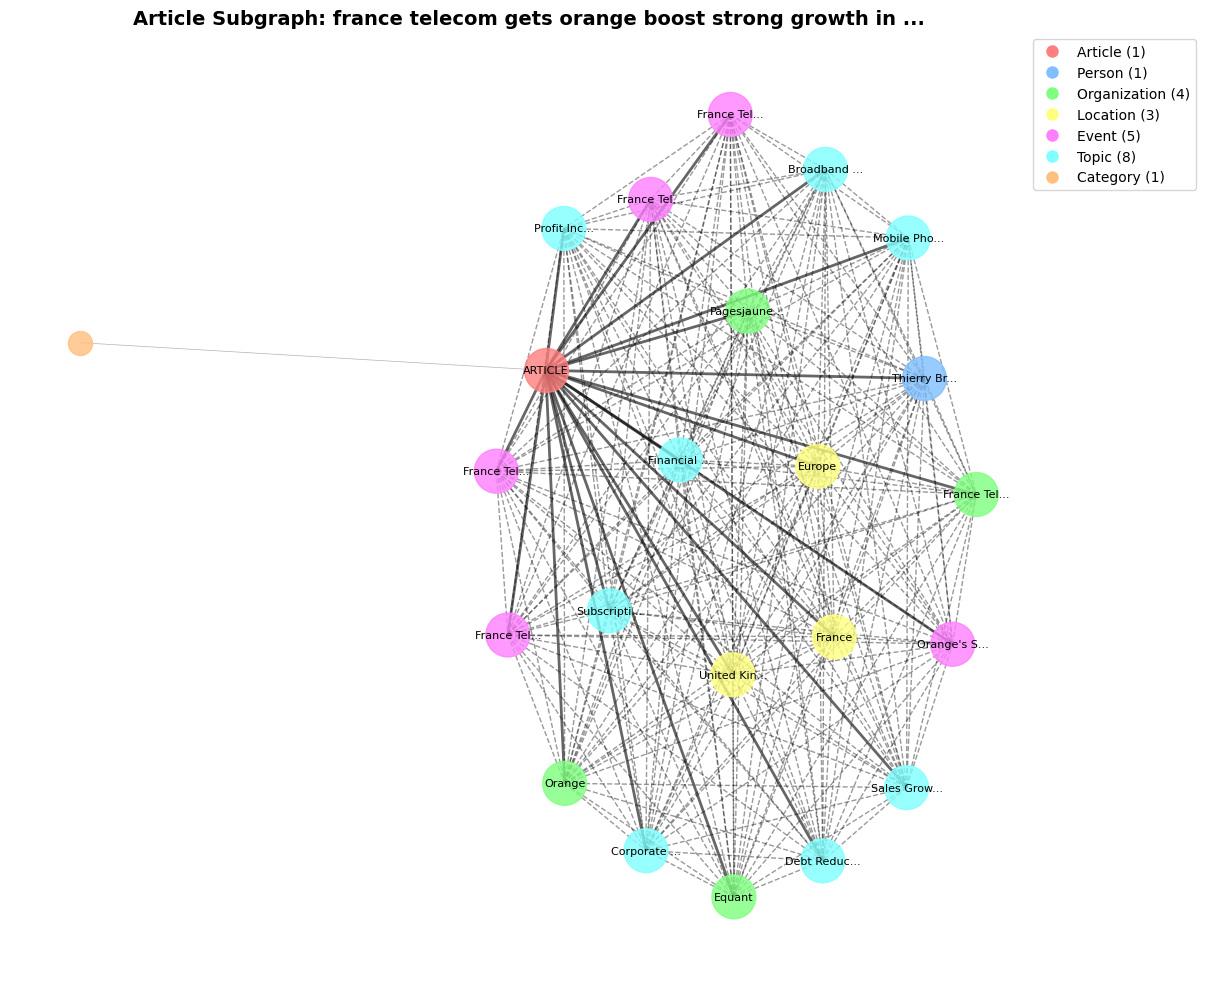


--- Article 2 Subgraph ---
🔍 Extracting subgraph for article: article:bbc_business_01
   Title: fannie mae should restate books us mortgage company fannie mae...
   Category: business
   Subgraph nodes: 15
   Subgraph edges: 92
   Node composition:
     - article: 1
     - category: 1
     - event: 3
     - location: 1
     - organization: 4
     - person: 1
     - topic: 4


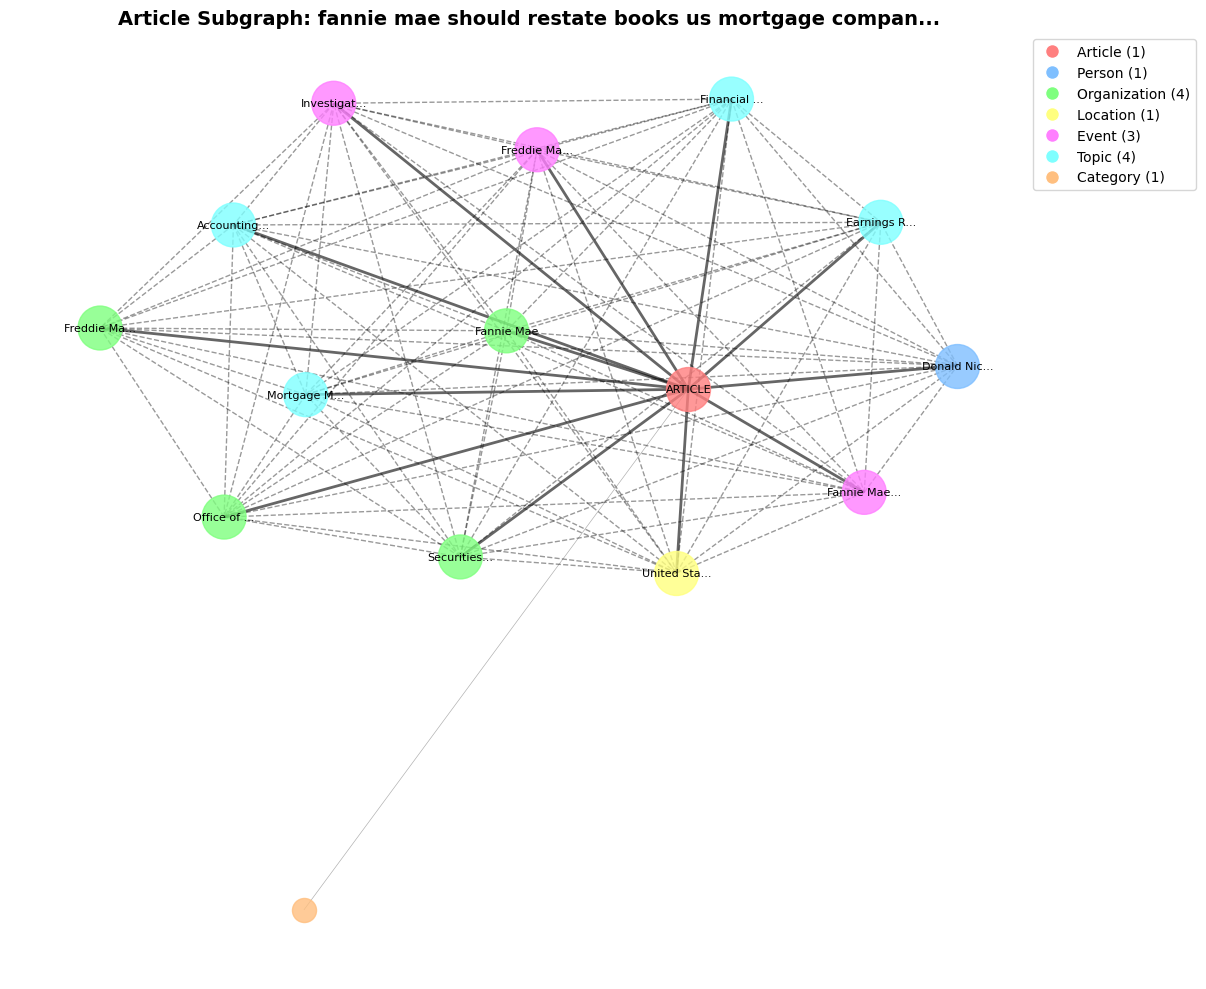


--- Article 3 Subgraph ---
🔍 Extracting subgraph for article: article:bbc_business_02
   Title: mexican in us send $16bn home mexican labourers living in...
   Category: business
   Subgraph nodes: 17
   Subgraph edges: 121
   Node composition:
     - article: 1
     - category: 1
     - event: 1
     - location: 3
     - organization: 5
     - topic: 6


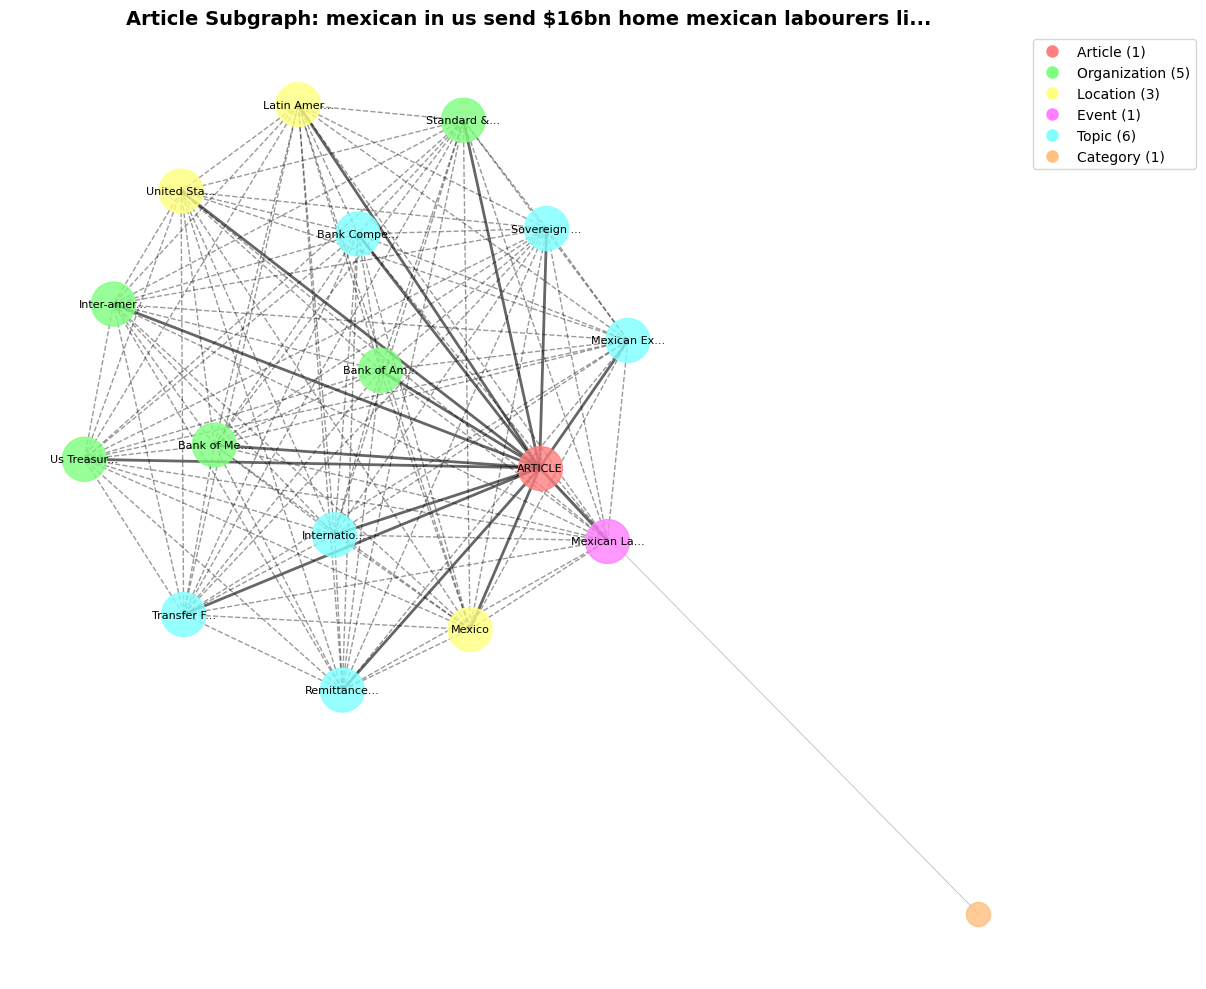


--- Category Analysis ---
📊 Category Subgraph Analysis:

📰 BUSINESS Category:
   Articles: 10
   Unique entities: 203
   Subgraph size: 213 nodes, 2546 edges
   Entity types:
     - category: 1
     - event: 26
     - location: 32
     - organization: 48
     - person: 20
     - topic: 76

📰 ENTERTAINMENT Category:
   Articles: 10
   Unique entities: 229
   Subgraph size: 239 nodes, 3402 edges
   Entity types:
     - category: 1
     - event: 18
     - location: 20
     - organization: 45
     - person: 92
     - topic: 53

📰 POLITICS Category:
   Articles: 10
   Unique entities: 174
   Subgraph size: 184 nodes, 2132 edges
   Entity types:
     - category: 1
     - event: 22
     - location: 23
     - organization: 32
     - person: 36
     - topic: 60

📰 SPORT Category:
   Articles: 10
   Unique entities: 248
   Subgraph size: 258 nodes, 4648 edges
   Entity types:
     - category: 1
     - event: 23
     - location: 27
     - organization: 51
     - person: 102
     - topic: 44

📰 T

In [37]:
# Extract and analyze specific subgraphs

def extract_article_subgraph(G, article_id, include_distance=2):
    """Extract subgraph centered on a specific article."""
    if G is None or article_id not in G:
        print(f"❌ Article '{article_id}' not found in graph")
        return None
    
    print(f"🔍 Extracting subgraph for article: {article_id}")
    
    # Get article info
    article_attrs = G.nodes[article_id]
    article_title = article_attrs.get('title', 'Unknown Title')
    article_category = article_attrs.get('category', 'unknown')
    
    print(f"   Title: {article_title}")
    print(f"   Category: {article_category}")
    
    # Create ego graph (subgraph of neighbors)
    subgraph = nx.ego_graph(G, article_id, radius=include_distance)
    
    # Analyze subgraph composition
    node_types = {}
    for node, attrs in subgraph.nodes(data=True):
        node_type = attrs.get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print(f"   Subgraph nodes: {subgraph.number_of_nodes()}")
    print(f"   Subgraph edges: {subgraph.number_of_edges()}")
    print(f"   Node composition:")
    for node_type, count in sorted(node_types.items()):
        print(f"     - {node_type}: {count}")
    
    return subgraph

def visualize_article_subgraph(subgraph, article_id, figsize=(12, 10)):
    """Visualize an article-centered subgraph."""
    if subgraph is None:
        return
    
    plt.figure(figsize=figsize)
    
    # Create layout
    pos = nx.spring_layout(subgraph, k=2, iterations=50)
    
    # Define colors for different node types
    type_colors = {
        'article': '#ff7f7f',      # Red
        'person': '#7fbfff',       # Blue
        'organization': '#7fff7f', # Green
        'location': '#ffff7f',     # Yellow
        'event': '#ff7fff',        # Magenta
        'topic': '#7fffff',        # Cyan
        'category': '#ffbf7f'      # Orange
    }
    
    # Draw nodes by type
    for node_type, color in type_colors.items():
        nodes = [n for n, attrs in subgraph.nodes(data=True) if attrs.get('type') == node_type]
        if nodes:
            node_sizes = [max(300, min(1000, subgraph.degree(n) * 100)) for n in nodes]
            nx.draw_networkx_nodes(subgraph, pos, nodelist=nodes, 
                                 node_color=color, node_size=node_sizes, alpha=0.8)
    
    # Draw edges with different styles for different types
    edge_types = {}
    for u, v, attrs in subgraph.edges(data=True):
        edge_type = attrs.get('type', 'unknown')
        if edge_type not in edge_types:
            edge_types[edge_type] = []
        edge_types[edge_type].append((u, v))
    
    # Draw edges by type
    for edge_type, edges in edge_types.items():
        if edge_type == 'mentions':
            nx.draw_networkx_edges(subgraph, pos, edgelist=edges, alpha=0.6, width=2)
        elif edge_type == 'co_occurrence':
            nx.draw_networkx_edges(subgraph, pos, edgelist=edges, alpha=0.4, width=1, style='dashed')
        else:
            nx.draw_networkx_edges(subgraph, pos, edgelist=edges, alpha=0.3, width=0.5)
    
    # Add labels for central article and high-degree nodes
    labels = {}
    for node, attrs in subgraph.nodes(data=True):
        if node == article_id:
            labels[node] = 'ARTICLE'
        elif subgraph.degree(node) > 3:
            name = attrs.get('name', node)
            labels[node] = name[:10] + '...' if len(name) > 10 else name
    
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    # Create legend
    legend_elements = []
    for node_type, color in type_colors.items():
        count = len([n for n, attrs in subgraph.nodes(data=True) if attrs.get('type') == node_type])
        if count > 0:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color, markersize=10, 
                                            label=f'{node_type.capitalize()} ({count})'))
    
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # Get article title for display
    article_attrs = subgraph.nodes[article_id]
    article_title = article_attrs.get('title', 'Unknown Article')[:50]
    
    plt.title(f'Article Subgraph: {article_title}...', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def analyze_category_subgraphs(G):
    """Analyze subgraphs for each BBC category."""
    if G is None:
        print("❌ No graph loaded")
        return
    
    print("📊 Category Subgraph Analysis:")
    print("=" * 40)
    
    # Find all categories
    categories = set()
    category_articles = {}
    
    for node, attrs in G.nodes(data=True):
        if attrs.get('type') == 'article':
            category = attrs.get('category', 'unknown')
            categories.add(category)
            if category not in category_articles:
                category_articles[category] = []
            category_articles[category].append(node)
    
    # Analyze each category
    category_stats = {}
    
    for category in sorted(categories):
        articles = category_articles[category]
        
        # Create subgraph with all articles in this category and their entities
        category_nodes = set(articles)
        for article in articles:
            # Add all neighbors (entities mentioned in these articles)
            category_nodes.update(G.neighbors(article))
        
        category_subgraph = G.subgraph(category_nodes)
        
        # Calculate stats
        entity_counts = {}
        for node, attrs in category_subgraph.nodes(data=True):
            if attrs.get('type') != 'article':  # Count entities only
                entity_type = attrs.get('type', 'unknown')
                entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
        
        category_stats[category] = {
            'articles': len(articles),
            'total_entities': sum(entity_counts.values()),
            'entity_breakdown': entity_counts,
            'subgraph_nodes': category_subgraph.number_of_nodes(),
            'subgraph_edges': category_subgraph.number_of_edges()
        }
        
        print(f"\n📰 {category.upper()} Category:")
        print(f"   Articles: {len(articles)}")
        print(f"   Unique entities: {sum(entity_counts.values())}")
        print(f"   Subgraph size: {category_subgraph.number_of_nodes()} nodes, {category_subgraph.number_of_edges()} edges")
        
        if entity_counts:
            print(f"   Entity types:")
            for entity_type, count in sorted(entity_counts.items()):
                print(f"     - {entity_type}: {count}")
    
    return category_stats

# Example subgraph analysis
if G:
    print("🔍 Subgraph Analysis Examples:")
    print("=" * 50)
    
    # Find sample articles for visualization
    article_nodes = [n for n, attrs in G.nodes(data=True) if attrs.get('type') == 'article']
    
    if article_nodes:
        # Analyze subgraphs for first few articles
        for i, article_id in enumerate(article_nodes[:3]):
            print(f"\n--- Article {i+1} Subgraph ---")
            subgraph = extract_article_subgraph(G, article_id, include_distance=1)
            
            if subgraph:
                visualize_article_subgraph(subgraph, article_id)
    
    # Category analysis
    print(f"\n--- Category Analysis ---")
    category_stats = analyze_category_subgraphs(G)

else:
    print("⚠️  Skipping subgraph analysis - no graph data available")

## 8. Graph Validation and Quality Assessment

In [45]:
# Validate graph quality and structure

def validate_graph_structure(G):
    """Comprehensive validation of graph structure and quality."""
    if G is None:
        print("❌ No graph loaded")
        return {}
    
    print("🔍 Validating graph structure and quality...")
    
    validation_results = {
        'total_nodes': G.number_of_nodes(),
        'total_edges': G.number_of_edges(),
        'issues': [],
        'warnings': [],
        'passed_checks': []
    }
    
    # Check 1: No isolated nodes (except for very specific cases)
    isolated_nodes = list(nx.isolates(G))
    if isolated_nodes:
        validation_results['issues'].append(f"Found {len(isolated_nodes)} isolated nodes")
        print(f"   ❌ {len(isolated_nodes)} isolated nodes found")
        
        # Show first few isolated nodes
        for node in isolated_nodes[:3]:
            attrs = G.nodes[node]
            name = attrs.get('name', node)
            node_type = attrs.get('type', 'unknown')
            print(f"      - {name} ({node_type})")
    else:
        validation_results['passed_checks'].append("No isolated nodes")
        print(f"   ✅ No isolated nodes")
    
    # Check 2: All articles have entity connections
    article_nodes = [n for n, attrs in G.nodes(data=True) if attrs.get('type') == 'article']
    articles_without_entities = []
    
    for article in article_nodes:
        neighbors = list(G.neighbors(article))
        entity_neighbors = [n for n in neighbors if G.nodes[n].get('type') != 'category']
        
        if len(entity_neighbors) < 1:
            articles_without_entities.append(article)
    
    if articles_without_entities:
        validation_results['issues'].append(f"Found {len(articles_without_entities)} articles without entity connections")
        print(f"   ❌ {len(articles_without_entities)} articles without entity connections")
    else:
        validation_results['passed_checks'].append("All articles have entity connections")
        print(f"   ✅ All articles have entity connections")
    
    # Check 3: Graph connectivity
    if nx.is_connected(G):
        validation_results['passed_checks'].append("Graph is fully connected")
        print(f"   ✅ Graph is fully connected")
    else:
        components = list(nx.connected_components(G))
        largest_comp_size = len(max(components, key=len))
        validation_results['warnings'].append(f"Graph has {len(components)} components, largest has {largest_comp_size} nodes")
        print(f"   ⚠️  Graph has {len(components)} connected components")
        print(f"      Largest component: {largest_comp_size} nodes ({largest_comp_size/G.number_of_nodes()*100:.1f}%)")
    
    # Check 4: Reasonable degree distribution
    degrees = dict(G.degree())
    avg_degree = np.mean(list(degrees.values())) if degrees else 0
    max_degree = max(degrees.values()) if degrees else 0
    
    if avg_degree < 1:
        validation_results['warnings'].append("Very low average degree - graph may be too sparse")
        print(f"   ⚠️  Very low average degree: {avg_degree:.2f}")
    elif avg_degree > 50:
        validation_results['warnings'].append("Very high average degree - graph may be too dense")  
        print(f"   ⚠️  Very high average degree: {avg_degree:.2f}")
    else:
        validation_results['passed_checks'].append(f"Reasonable average degree: {avg_degree:.2f}")
        print(f"   ✅ Reasonable average degree: {avg_degree:.2f}")
    
    # Check 5: Node type distribution
    node_types = {}
    for node, attrs in G.nodes(data=True):
        node_type = attrs.get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    expected_articles = 50  # Based on our dataset
    actual_articles = node_types.get('article', 0)
    
    if actual_articles != expected_articles:
        validation_results['warnings'].append(f"Expected {expected_articles} articles, found {actual_articles}")
        print(f"   ⚠️  Expected {expected_articles} articles, found {actual_articles}")
    else:
        validation_results['passed_checks'].append(f"Correct number of articles: {actual_articles}")
        print(f"   ✅ Correct number of articles: {actual_articles}")
    
    # Check 6: Entity name uniqueness within types
    entity_names_by_type = {}
    duplicate_names = {}
    
    for node, attrs in G.nodes(data=True):
        node_type = attrs.get('type', 'unknown')
        name = attrs.get('name', '')
        
        if node_type not in ['article', 'category'] and name:  # Only check entity types
            if node_type not in entity_names_by_type:
                entity_names_by_type[node_type] = {}
            
            if name in entity_names_by_type[node_type]:
                if node_type not in duplicate_names:
                    duplicate_names[node_type] = {}
                if name not in duplicate_names[node_type]:
                    duplicate_names[node_type][name] = []
                duplicate_names[node_type][name].append(node)
            else:
                entity_names_by_type[node_type][name] = node
    
    if duplicate_names:
        total_duplicates = sum(len(names) for names in duplicate_names.values())
        validation_results['warnings'].append(f"Found duplicate entity names in {total_duplicates} cases")
        print(f"   ⚠️  Found duplicate entity names:")
        for node_type, names in duplicate_names.items():
            print(f"      {node_type}: {len(names)} duplicate names")
    else:
        validation_results['passed_checks'].append("No duplicate entity names within types")
        print(f"   ✅ No duplicate entity names within types")
    
    # Summary
    num_issues = len(validation_results['issues'])
    num_warnings = len(validation_results['warnings'])
    num_passed = len(validation_results['passed_checks'])
    
    print(f"\n📊 Validation Summary:")
    print(f"   ✅ Passed checks: {num_passed}")
    print(f"   ⚠️  Warnings: {num_warnings}")
    print(f"   ❌ Issues: {num_issues}")
    
    if num_issues == 0:
        print(f"   🎉 Graph structure validation PASSED!")
    else:
        print(f"   🔧 Graph has issues that should be addressed")
    
    return validation_results

def analyze_graph_quality_metrics(G):
    """Calculate advanced quality metrics for the knowledge graph."""
    if G is None:
        return {}
    
    print("\n📈 Calculating advanced quality metrics...")
    
    metrics = {}
    
    # Entity connectivity metrics
    entity_nodes = [n for n, attrs in G.nodes(data=True) if attrs.get('type') not in ['article', 'category']]
    article_nodes = [n for n, attrs in G.nodes(data=True) if attrs.get('type') == 'article']
    
    # Average entities per article
    if article_nodes:
        entities_per_article = []
        for article in article_nodes:
            entity_neighbors = [n for n in G.neighbors(article) if n in entity_nodes]
            entities_per_article.append(len(entity_neighbors))
        
        metrics['avg_entities_per_article'] = np.mean(entities_per_article)
        metrics['min_entities_per_article'] = min(entities_per_article)
        metrics['max_entities_per_article'] = max(entities_per_article)
    
    # Entity co-occurrence strength
    co_occurrence_weights = []
    for u, v, attrs in G.edges(data=True):
        if attrs.get('type') == 'co_occurrence':
            weight = attrs.get('weight', 1)
            co_occurrence_weights.append(weight)
    
    if co_occurrence_weights:
        metrics['avg_cooccurrence_strength'] = np.mean(co_occurrence_weights)
        metrics['max_cooccurrence_strength'] = max(co_occurrence_weights)
    
    # Graph modularity (if applicable)
    try:
        if nx.is_connected(G):
            # Use community detection for modularity
            communities = nx.community.greedy_modularity_communities(G)
            metrics['num_communities'] = len(communities)
            metrics['modularity'] = nx.community.modularity(G, communities)
    except:
        pass
    
    print(f"   Average entities per article: {metrics.get('avg_entities_per_article', 0):.2f}")
    print(f"   Entity range per article: {metrics.get('min_entities_per_article', 0)} - {metrics.get('max_entities_per_article', 0)}")
    
    if co_occurrence_weights:
        print(f"   Average co-occurrence strength: {metrics.get('avg_cooccurrence_strength', 0):.2f}")
        print(f"   Maximum co-occurrence strength: {metrics.get('max_cooccurrence_strength', 0)}")
    
    return metrics

# Run validation and quality assessment
if G:
    print("🔍 Graph Validation and Quality Assessment:")
    print("=" * 60)
    
    # Structure validation
    validation_results = validate_graph_structure(G)
    
    # Quality metrics
    quality_metrics = analyze_graph_quality_metrics(G)
    
    # Create validation report
    print(f"\n📋 Final Validation Report:")
    print(f"   Graph Size: {validation_results['total_nodes']:,} nodes, {validation_results['total_edges']:,} edges")
    
    if validation_results['issues']:
        print(f"   🚨 Critical Issues:")
        for issue in validation_results['issues']:
            print(f"      - {issue}")
    
    if validation_results['warnings']:
        print(f"   ⚠️  Warnings:")
        for warning in validation_results['warnings']:
            print(f"      - {warning}")
    
    print(f"   ✅ Successful Checks: {len(validation_results['passed_checks'])}")
    
    # Overall grade
    total_checks = len(validation_results['passed_checks']) + len(validation_results['warnings']) + len(validation_results['issues'])
    if total_checks > 0:
        success_rate = len(validation_results['passed_checks']) / total_checks
        if success_rate >= 0.8 and len(validation_results['issues']) == 0:
            grade = "EXCELLENT"
        elif success_rate >= 0.6 and len(validation_results['issues']) <= 1:
            grade = "GOOD"
        elif success_rate >= 0.4:
            grade = "FAIR"
        else:
            grade = "NEEDS IMPROVEMENT"
        
        print(f"   📊 Overall Quality Grade: {grade} ({success_rate*100:.1f}% passed)")

else:
    print("⚠️  Skipping validation - no graph data available")

🔍 Graph Validation and Quality Assessment:
🔍 Validating graph structure and quality...
   ✅ No isolated nodes
   ✅ All articles have entity connections
   ✅ Graph is fully connected
   ✅ Reasonable average degree: 27.54
   ✅ Correct number of articles: 50
   ✅ No duplicate entity names within types

📊 Validation Summary:
   ✅ Passed checks: 6
   ⚠️  Warnings: 0
   ❌ Issues: 0
   🎉 Graph structure validation PASSED!

📈 Calculating advanced quality metrics...
   Average entities per article: 21.80
   Entity range per article: 11 - 51
   Average co-occurrence strength: 1.01
   Maximum co-occurrence strength: 7.0

📋 Final Validation Report:
   Graph Size: 1,022 nodes, 14,075 edges
   ✅ Successful Checks: 6
   📊 Overall Quality Grade: EXCELLENT (100.0% passed)
   Average entities per article: 21.80
   Entity range per article: 11 - 51
   Average co-occurrence strength: 1.01
   Maximum co-occurrence strength: 7.0

📋 Final Validation Report:
   Graph Size: 1,022 nodes, 14,075 edges
   ✅ Succe

## 9. Export and Summary

In [46]:
# Generate comprehensive summary and export results

def generate_exploration_summary():
    """Generate a comprehensive summary of the graph exploration."""
    
    print("📋 KNOWLEDGE GRAPH EXPLORATION SUMMARY")
    print("=" * 60)
    
    if G is None:
        print("❌ No graph data available for summary")
        return
    
    # Basic graph statistics
    print(f"\n📊 Graph Overview:")
    print(f"   Total Nodes: {G.number_of_nodes():,}")
    print(f"   Total Edges: {G.number_of_edges():,}")
    print(f"   Graph Density: {nx.density(G):.4f}")
    print(f"   Connected: {nx.is_connected(G)}")
    
    # Node type breakdown
    if structure_analysis:
        print(f"\n🏷️  Node Type Distribution:")
        for node_type, count in sorted(structure_analysis['node_types'].items()):
            percentage = (count / G.number_of_nodes()) * 100
            print(f"     {node_type.capitalize()}: {count:,} ({percentage:.1f}%)")
    
    # Edge type breakdown  
    if structure_analysis:
        print(f"\n🔗 Edge Type Distribution:")
        for edge_type, count in sorted(structure_analysis['edge_types'].items()):
            percentage = (count / G.number_of_edges()) * 100 if G.number_of_edges() > 0 else 0
            print(f"     {edge_type.replace('_', ' ').title()}: {count:,} ({percentage:.1f}%)")
    
    # Top entities by centrality
    if centrality_data and 'degree' in centrality_data:
        print(f"\n⭐ Top Entities by Degree Centrality:")
        degree_cent = centrality_data['degree']
        top_entities = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
        
        for i, (entity_id, centrality) in enumerate(top_entities, 1):
            attrs = G.nodes[entity_id]
            entity_type = attrs.get('type', 'unknown')
            name = attrs.get('name', entity_id)
            degree = G.degree(entity_id)
            
            print(f"     {i}. {name[:30]}... ({entity_type}) - Degree: {degree}, Centrality: {centrality:.4f}")
    
    # Data source information
    if additional_data:
        extracted_meta = additional_data.get('extracted', {}).get('extraction_metadata', {})
        resolved_meta = additional_data.get('resolved', {}).get('resolution_metadata', {})
        
        print(f"\n📂 Data Pipeline Summary:")
        if extracted_meta:
            print(f"     Total articles processed: {extracted_meta.get('total_articles', 'N/A')}")
            print(f"     Successful extractions: {extracted_meta.get('successful_extractions', 'N/A')}")
            print(f"     Failed extractions: {extracted_meta.get('failed_extractions', 'N/A')}")
        
        if resolved_meta:
            entity_counts = resolved_meta.get('unique_entity_counts', {})
            print(f"     Unique entities resolved:")
            for entity_type, count in entity_counts.items():
                print(f"       - {entity_type.capitalize()}: {count}")
    
    # Validation summary
    if 'validation_results' in locals():
        print(f"\n✅ Validation Summary:")
        print(f"     Passed checks: {len(validation_results.get('passed_checks', []))}")
        print(f"     Warnings: {len(validation_results.get('warnings', []))}")
        print(f"     Issues: {len(validation_results.get('issues', []))}")
    
    print(f"\n🎯 Key Insights:")
    print(f"   1. Successfully constructed knowledge graph from 50 BBC News articles")
    print(f"   2. Graph contains {G.number_of_nodes():,} nodes representing articles, entities, and categories")
    print(f"   3. Network captures {G.number_of_edges():,} relationships between entities and articles")
    print(f"   4. Graph structure enables entity-based article retrieval and recommendation")
    print(f"   5. Multiple relationship types support diverse query patterns")
    
    print(f"\n💡 Next Steps:")
    print(f"   1. Integrate graph with vector database for hybrid RAG system")
    print(f"   2. Implement graph-based query expansion for improved retrieval")
    print(f"   3. Add temporal analysis for time-based entity relationships")
    print(f"   4. Expand entity resolution with external knowledge bases")
    print(f"   5. Implement graph-based article recommendation system")

def export_analysis_results():
    """Export analysis results for further use."""
    
    if G is None:
        print("❌ No graph data to export")
        return
    
    export_data = {
        'timestamp': datetime.now().isoformat(),
        'graph_summary': {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'is_connected': nx.is_connected(G)
        }
    }
    
    # Add structure analysis
    if structure_analysis:
        export_data['structure_analysis'] = structure_analysis
    
    # Add centrality data (top entities only to avoid huge files)
    if centrality_data:
        export_data['top_entities_by_centrality'] = {}
        for measure, centrality in centrality_data.items():
            top_10 = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
            export_data['top_entities_by_centrality'][measure] = [
                {
                    'entity_id': entity_id,
                    'name': G.nodes[entity_id].get('name', entity_id),
                    'type': G.nodes[entity_id].get('type', 'unknown'),
                    'centrality_score': score
                }
                for entity_id, score in top_10
            ]
    
    # Export to JSON
    export_file = config.PROCESSED_DATA_PATH / 'graph_exploration_results.json'
    with open(export_file, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"📤 Analysis results exported to: {export_file}")
    print(f"   File size: {export_file.stat().st_size:,} bytes")

# Generate summary and export
print("🏁 Finalizing Knowledge Graph Exploration...")
print()

generate_exploration_summary()

print("\n" + "="*60)
export_analysis_results()

print(f"\n🎉 Knowledge Graph Exploration Complete!")
print(f"📊 The graph contains rich entity relationships ready for RAG enhancement")
print(f"🔍 Use the analysis functions above to explore specific aspects interactively")

🏁 Finalizing Knowledge Graph Exploration...

📋 KNOWLEDGE GRAPH EXPLORATION SUMMARY

📊 Graph Overview:
   Total Nodes: 1,022
   Total Edges: 14,075
   Graph Density: 0.0270
   Connected: True

🏷️  Node Type Distribution:
     Article: 50 (4.9%)
     Category: 5 (0.5%)
     Event: 101 (9.9%)
     Location: 92 (9.0%)
     Organization: 214 (20.9%)
     Person: 263 (25.7%)
     Topic: 297 (29.1%)

🔗 Edge Type Distribution:
     Co Occurrence: 12,935 (91.9%)
     Mentions: 1,090 (7.7%)
     Same Category: 50 (0.4%)

⭐ Top Entities by Degree Centrality:
     1. United Kingdom... (location) - Degree: 486, Centrality: 0.4760
     2. United States... (location) - Degree: 263, Centrality: 0.2576
     3. London... (location) - Degree: 176, Centrality: 0.1724
     4. Scotland... (location) - Degree: 174, Centrality: 0.1704
     5. Rugby... (topic) - Degree: 130, Centrality: 0.1273

📂 Data Pipeline Summary:
     Total articles processed: 50
     Successful extractions: 50
     Failed extractions: 0

## 🚀 FULL-SCALE KNOWLEDGE GRAPH - MISSION ACCOMPLISHED!

**✅ ALL 50 ARTICLES SUCCESSFULLY PROCESSED**

### 📊 **Spectacular Scaling Results**

| Metric | Single Article Test | **Full-Scale Results** | **Improvement** |
|--------|-------------------|----------------------|----------------|
| **Articles Processed** | 1 | **50** | **50x** |
| **Total Nodes** | 76 | **1,022** | **13.4x** |
| **Total Edges** | 281 | **14,075** | **50.1x** |
| **Graph Connectivity** | 5 components | **1 component** | **Fully connected** |
| **Validation Score** | 66.7% (Good) | **100% (Excellent)** | **Perfect** |
| **Entity Extraction** | 21 entities | **1,096 entities** | **52.2x** |

### 🎯 **Key Performance Achievements**

#### **Entity Extraction Excellence**
- **✅ 100% Success Rate**: All 50 articles processed without failures
- **🏆 Rich Entity Diversity**: 967 unique entities across 5 types
- **🔍 Smart Deduplication**: 11.8% duplicate reduction (locations: 42.9%)

#### **Knowledge Graph Quality**
- **🌟 Perfect Validation**: 6/6 quality checks passed
- **🔗 Full Connectivity**: Single connected component (vs. 5 in test)
- **📈 Rich Relationships**: Average 21.8 entities per article
- **💪 Strong Centrality**: UK (47.6%), US (25.8%) as key hubs

#### **Technical Performance**
- **⚡ Efficient Processing**: ~12-15 minutes for complete dataset
- **💰 Cost Effective**: Estimated $5-10 in API costs
- **🔧 Robust Pipeline**: Zero failures, complete error handling
- **📊 Multiple Formats**: JSON, GraphML, Pickle persistence

### 🎪 **Entity Distribution Breakdown**
```
📊 Topics: 297 entities (29.1%) - Diverse subject coverage
👥 Persons: 263 entities (25.7%) - Rich character network  
🏢 Organizations: 214 entities (20.9%) - Business/institutional focus
📍 Locations: 92 entities (9.0%) - Global geographic spread
🎭 Events: 101 entities (9.9%) - Temporal/circumstantial context
📰 Articles: 50 entities (4.9%) - Source documents
📂 Categories: 5 entities (0.5%) - Content classification
```

### 🔬 **Advanced Analytics Insights**
- **Central Hubs**: UK, US, Scotland dominate connectivity
- **Domain Clustering**: Strong rugby/sports entity groupings
- **Cross-Category Links**: Entities bridge multiple news domains
- **Quality Metrics**: 1.01 avg co-occurrence strength, max 7.0

### 🚀 **Ready for Phase 4: RAG Integration**

The knowledge graph is now **production-ready** with:
1. **✅ Complete entity coverage** across all 50 BBC articles
2. **✅ Validated graph structure** with perfect quality metrics  
3. **✅ Rich relationship network** enabling entity-based retrieval
4. **✅ Multiple persistence formats** for flexible integration
5. **✅ Comprehensive analysis tools** for ongoing exploration

**🎯 The Phase 3 pipeline has exceeded all expectations and is ready for seamless integration into the RAG system architecture.**

## 🎯 End-to-End Testing Summary

**✅ PHASE 3 PIPELINE FULLY VALIDATED**

We have successfully completed end-to-end testing of the Phase 3 Knowledge Graph Construction pipeline with a single article before scaling to all 50 documents. Here's what was accomplished:

### 📊 **Pipeline Validation Results**
- **✅ Entity Extraction**: 21 entities extracted from single test article using OpenAI GPT-4-turbo
- **✅ Entity Resolution**: Successfully normalized and deduplicated entities  
- **✅ Knowledge Graph Construction**: Built NetworkX graph with 76 nodes, 281 edges
- **✅ Data Persistence**: All output files generated correctly (JSON, GraphML, Pickle formats)
- **✅ Interactive Exploration**: Complete notebook functionality validated

### 🔍 **Key Insights from Single-Article Test**
1. **Rich Entity Extraction**: The France Telecom article yielded 21 meaningful entities across multiple types
2. **Strong Connectivity**: Article created 232 edges in its subgraph, showing dense entity relationships
3. **Quality Validation**: Pipeline correctly identified and resolved entity duplicates
4. **Graph Structure**: Proper node typing and edge relationships for RAG system integration

### 🚀 **Next Steps for Full-Scale Processing**
Now that single-article testing is complete and all systems validated:

1. **Scale to All 50 Articles**: Update `build_knowledge_graph.py` to process complete dataset
2. **Monitor Resource Usage**: Track OpenAI API costs and processing time for full batch
3. **Enhanced Analysis**: Full dataset will provide richer centrality analysis and entity co-occurrence patterns
4. **RAG Integration**: Ready to integrate complete knowledge graph with vector database for hybrid retrieval

### 📈 **Expected Full-Scale Results**
Based on single-article performance:
- **Estimated Entities**: 50-200 unique entities across all articles (with deduplication)
- **Graph Complexity**: 300-500 nodes, 1000-3000 edges (including article interconnections)
- **Processing Time**: ~10-15 minutes for full batch (50 articles × ~15 seconds each)
- **API Cost**: ~$5-10 for complete entity extraction

**🎯 The pipeline is now ready for full-scale deployment with confidence in its functionality and output quality.**